In [1]:
import numpy as np

from nfvm.mesh.triangleMesh import TriangleMesh
from nfvm.field.volField import volScalarField
import nfvm.fvm as fvm
import nfvm.fvc as fvc

import matplotlib.pyplot as plt

# 俄罗斯方块 Cleveland 几何算例

俄罗斯方块中的 **Z** 方块名字为 Cleveland， 这里基于其构建一个传热问题，左侧壁面310K，右侧壁面290K，其余边界为0梯度边界条件；并且上半部分和下半部分导热系数不同。

## 加载点和控制体

从 ../../resources/mesh/cleveland/cleveland.msh 加载网格...

重构网格拓扑关系 ...
重构网格拓扑关系 成功
初始化 TriangleMesh ...
初始化 TriangleMesh 成功


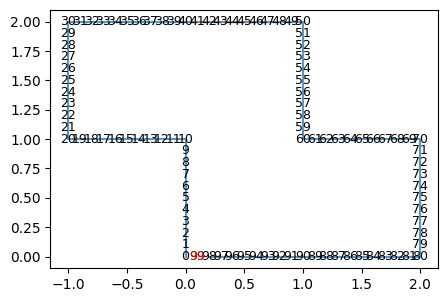

In [2]:
mesh = TriangleMesh.fromMeshIO("../../resources/mesh/cleveland/cleveland.msh")
mesh.boundary.moveStart2Point(5)
mesh.showBoundary(pause=False)

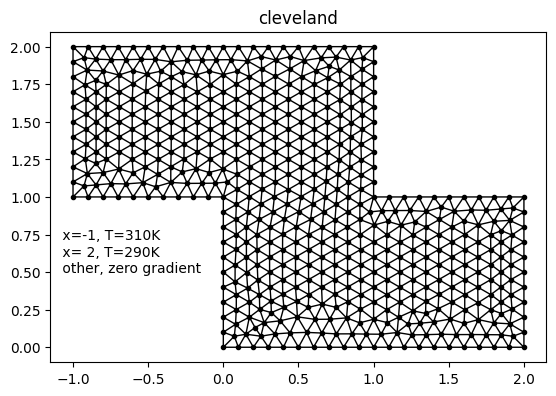

In [3]:
# 网格可视化

X = mesh.points[:,0]
Y = mesh.points[:,1]
triangles = mesh.cells 

fig, ax = plt.subplots()
ax.set_aspect('equal')
tpc = ax.triplot(X, Y, triangles, 'ko-', markersize=3, lw=1.0)
ax.set_title('cleveland')

ax.text(-1.1,0.5, " x=-1, T=310K\n x= 2, T=290K\n other, zero gradient")

plt.show()

## 构造一个温度场

In [4]:
# 构造一个边界条
BN:int = 100
k, b = np.ones(BN), np.zeros(BN)

# 20-40温度为310 
k[20:30] = 0.0
b[20:30] = 310.0
# 60-80温度为300，
k[70:80] = 0.0
b[70:80] = 290.0
# 0-20&40-60为绝热条件（0梯度条件），默认的 k=1.0, b=0.0就是0梯度

In [5]:
# 构造一个温度场并指定初始值

CN = mesh.cn
T = volScalarField("T", mesh, value=np.ones(CN)*300.0, boundary_dict={'k': k, 'b': b})

In [6]:
# 一个导热系数场，几何的上半部分和下半部分导热系数不同

# 默认零梯度边界，上半部分为1
gamma = volScalarField("gamma", mesh, value=np.ones(CN))

# 下半部分为5
for i in range(mesh.cn):
    cy = mesh.cell_center[i, 1]
    if(cy>1): # 上半部分导热系数
        gamma[i] = 5
        
gamma_f = fvc.scalarInterpolate(gamma, scheme="linear")

## 使用拉普拉斯算子构造稀疏矩阵

In [7]:
mat = fvm.Laplacian(T, gamma_f.value)

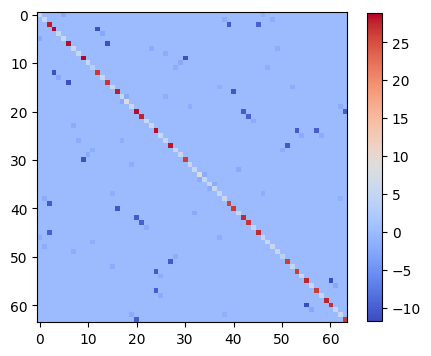

In [8]:
# 可视化稀疏矩阵
plt.figure(figsize=(5,5))

plt.imshow(mat.csr.todense()[:64,:64], cmap='coolwarm')
plt.colorbar(shrink=0.8)
# plt.savefig('sp-mat.png', dpi=150, bbox_inches='tight')
plt.show()

## 求解稀疏矩阵

使用`scipy.sparse.linalg`模块的`spsolve`函数求解稀疏矩阵。

In [9]:
# assignment 指定更新标量场T
_ = mat.solve(assignment=True)
# T.writeVTK()

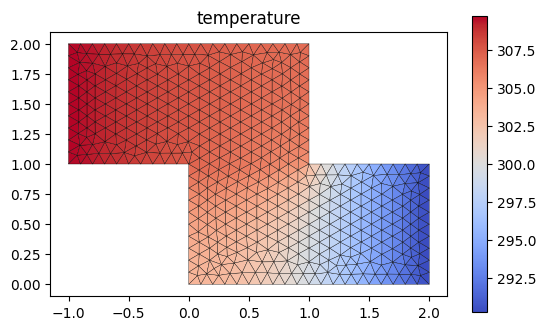

In [10]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
tpc = ax.tripcolor(X, Y, triangles, facecolors=T.value, cmap='coolwarm', edgecolors='k')
fig.colorbar(tpc, shrink=0.8)
ax.set_title('temperature')

plt.show()